In [1]:
import os
import warnings
import shutil
warnings.filterwarnings(action='ignore')


import math
#import pandas as pd
#import librosa
#import librosa.display
import glob
import numpy as np
#import seaborn as sns; sns.set(style='whitegrid')

import random
import time

from sklearn.utils import shuffle, class_weight
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from PIL import Image
from tqdm import tqdm,tnrange,tqdm_notebook
import tensorflow as tf
from tqdm.keras import TqdmCallback
from tensorflow.keras import backend as K 
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications as app
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,AveragePooling2D#, CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetB4, ResNet50, ResNet101, VGG16, MobileNet, InceptionV3, EfficientNetB2, densenet, ConvNeXtTiny
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt

model_type = 'convnexttiny'

2023-07-18 15:50:56.790308: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

def set_device_tf():    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only use the first GPU
      try:
        tf.config.experimental.set_visible_devices(gpus, 'GPU')
        print(gpus)
      except RuntimeError as e:
        # Visible devices must be set at program startup
        print(e)
    else:
      print("No GPUs found")

#  Plotting function.
def plot_accuracy_and_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training')
  plt.plot(val_acc, label='Validation')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1.05])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training')
  plt.plot(val_loss, label='Validation')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([np.min(np.concatenate((val_loss,loss)))-0.1,np.max(np.concatenate((val_loss,loss)))+0.1])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
  plt.close('all')

In [3]:
set_device_tf()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
# Data loading.
def load_data(train_dir, test_dir):
  BATCH_SIZE = 32 # 64 can fill up GPU memory!
  IMG_SIZE = (224, 224)
  AUTOTUNE = tf.data.AUTOTUNE
    
  if train_dir is not None:
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  shuffle=True,
                                                                  validation_split=.2, ##RECENT CHANGE
                                                                  seed=123,
                                                                  subset='training',
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)

    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  shuffle=True,
                                                                  validation_split=.2, ##RECENT CHANGE
                                                                  seed=123,
                                                                  subset='validation',
                                                                  batch_size=BATCH_SIZE,
                                                                  image_size=IMG_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
  else:
    train_dataset = None
    validation_dataset = None
        
  if test_dir is not None:
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  shuffle=False,
                                                                  image_size=IMG_SIZE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

  else:
    test_dataset = None

  return train_dataset, validation_dataset, test_dataset


In [5]:
def compute_weights(train_dataset, validation_dataset):
  num_fails = 0
  num_passes = 0
  for images, labels in train_dataset:
      labels_np = labels.numpy()
      passes = np.count_nonzero(labels_np)
      num_passes = num_passes + passes
      fails = len(labels_np) - passes
      num_fails = num_fails + fails
      
  total = num_fails + num_passes
  print('Train Examples:\n    Total: {}\n, Passes: {}, Fails: {} ({:.2f}% of total)\n'.format(
      total, num_passes, num_fails, 100 * num_fails / total))

  # Class weights
  weight_for_fail = (1 / num_fails) * (total / 2.0)
  weight_for_passes = (1 / num_passes) * (total / 2.0)

  class_weights = {0: weight_for_fail, 1: weight_for_passes}

  print('Weight for class 0 (Fail): {:.2f}'.format(weight_for_fail))
  print('Weight for class 1 (Pass): {:.2f}'.format(weight_for_passes))

  # Number of validation classes
  num_fails = 0
  num_passes = 0
  for images, labels in validation_dataset:
    labels_np = labels.numpy()
    passes = np.count_nonzero(labels_np)
    num_passes = num_passes + passes
    fails = len(labels_np) - passes
    num_fails = num_fails + fails
    
  total = num_fails + num_passes
  print('Validation Examples: Total: {}\n, Passes: {}, Fails: {} ({:.2f}% of total)\n'.format(
    total, num_passes, num_fails, 100 * num_fails / total))
  
  return class_weights

def compute_weights_scipy(train_dataset):
  num_fails = 0
  num_passes = 0
  concat_labels = []
  for images, labels in train_dataset:
      labels_np = labels.numpy()
      concat_labels.extend(list(labels_np))
      passes = np.count_nonzero(labels_np)
      num_passes = num_passes + passes
      fails = len(labels_np) - passes
      num_fails = num_fails + fails
    
  print(concat_labels)
  class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                     classes = np.unique(concat_labels),
                                                     y = concat_labels)
  print("Class weights (SCIPY): " + str(class_weights))
  return class_weights

In [6]:
"""
class DenseNetWithDropout(densenet.DenseNet121):
    def __init__(self, dropout_rate=0.5, *args, **kwargs):
        super(DenseNetWithDropout, self).__init__(*args, **kwargs)
        self.dropout_rate = dropout_rate

        custom_layers = []

        # Iterate through base model layers
        for layer in self.layers:
            custom_layers.append(layer)

            # Add dropout layer after each transition block
            if isinstance(layer, layers.MaxPooling2D):
                custom_layers.append(layers.Dropout(self.dropout_rate))

        self.layers = custom_layers
"""

'\nclass DenseNetWithDropout(densenet.DenseNet121):\n    def __init__(self, dropout_rate=0.5, *args, **kwargs):\n        super(DenseNetWithDropout, self).__init__(*args, **kwargs)\n        self.dropout_rate = dropout_rate\n\n        custom_layers = []\n\n        # Iterate through base model layers\n        for layer in self.layers:\n            custom_layers.append(layer)\n\n            # Add dropout layer after each transition block\n            if isinstance(layer, layers.MaxPooling2D):\n                custom_layers.append(layers.Dropout(self.dropout_rate))\n\n        self.layers = custom_layers\n'

In [7]:
# Create the base model from the pre-trained model MobileNet V2
def get_model(training=True, base_learning_rate = 0.0001, IMG_SIZE = (224, 224), model_type = model_type):
    IMG_SHAPE = IMG_SIZE + (3,)

    ## Densenet, convnext, resnet50

    base_model_trainable = True

    if model_type != "custom":
        if model_type == "mobilenet":
            ## MOBILENETV2
            base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                          weights='imagenet')
            preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
            fine_tune_at = 154 - 15
        elif model_type == "resnet":
            ## RESNET50
            base_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                        weights='imagenet')
            preprocess_input = tf.keras.applications.resnet50.preprocess_input
            fine_tune_at = 175 # was 29
        
        elif model_type == "densenet":
            print("DENSENET SELECTED")
            ## Densenet
            base_model = tf.keras.applications.densenet.DenseNet121(input_shape=IMG_SHAPE,
                                                          include_top=False,
                                                        weights='imagenet')
            preprocess_input = tf.keras.applications.densenet.preprocess_input
            fine_tune_at = 427 - 20 #52 #35 #375 #312 #10 #427 - 100 #427 - 20
        elif model_type == "densenet with dropout":
            ## Densenet
            base_model = DenseNetWithDropout(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
            preprocess_input = tf.keras.applications.densenet.preprocess_input
            fine_tune_at = 300
        elif model_type == "vgg16":
            ## Vgg16
            base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                        include_top=False,
                                                      weights='imagenet')
            preprocess_input = tf.keras.applications.vgg16.preprocess_input
        elif model_type == "convnexttiny":
            print("CONVNEXT SELECTED")
            # convnexttiny
            base_model = ConvNeXtTiny(input_shape=IMG_SHAPE,
                                      include_top=False,
                                      weights='imagenet')
            preprocess_input = tf.keras.applications.convnext.preprocess_input
            fine_tune_at = 132 #126 #was 132
            



        #image_batch, label_batch = next(iter(train_dataset))
        #feature_batch = base_model(image_batch)
        print("Number of layers = " + str(len(base_model.layers)))
        
   
        if base_model_trainable:
            base_model.trainable = True
            base_learning_rate = base_learning_rate/10

        
            # Fine-tune from this layer onwards 
            print("Number of layers = " + str(len(base_model.layers)))
        
            # Freeze all the layers before the `fine_tune_at` layer
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
            '''
            # freeze all layers after a certain layer
            for layer in base_model.layers[fine_tune_at:]:
                layer.trainable = False
            '''
        else:
             base_model.trainable = False
        
        
        """
        # Set the starting point for fine-tuning
        base_model.trainable = True
        fine_tune_at = None
        base_learning_rate = base_learning_rate/100
        for i, layer in enumerate(base_model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D) and layer.name.endswith("conv5_block1_1_conv"):
                fine_tune_at = i
                break
        
        print("Starting fine tuning at layer = " + str(fine_tune_at))
        if fine_tune_at:
            # Unfreeze all layers from the fine-tuning starting point
            for layer in base_model.layers[:fine_tune_at]:
                layer.trainable = False
        else:
            print("Fine-tuning starting point not found")
         """
       
    

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        #feature_batch_average = global_average_layer(feature_batch)
        #print(feature_batch_average.shape)

        prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
        #prediction_batch = prediction_layer(feature_batch_average)
        #print(prediction_batch.shape)


        inputs = tf.keras.Input(shape=(224, 224, 3))
        x = preprocess_input(inputs)
        x = base_model(x) #was training=False
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.8)(x, training=training)
        outputs = prediction_layer(x)
        model = tf.keras.Model(inputs, outputs)


    elif model_type == "custom":
        model = tf.keras.Sequential([
          tf.keras.layers.Rescaling(1./255),
          tf.keras.layers.Conv2D(12, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(24, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(48, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
          tf.keras.layers.Dropout(0.6),
          tf.keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy']) # recent change - added weight decay, subsequently removed , weight_decay=0.0005


    return model

In [8]:
def get_test_model(model_type):
  test_model = get_model(training=False, model_type=model_type)
  test_model.load_weights("Weights/" + model_type + ".h5")

  return test_model

def get_performance(model, test_dataset):
  loss, accuracy = model.evaluate(test_dataset)
  print('Test accuracy :', accuracy)
  return accuracy

def predict_on_dataset(model, dataset):
    labels = []
    predictions = []

    for images, image_labels in dataset:
        preds = model.predict(images)
        predictions.extend(preds)
        labels.extend(image_labels.numpy())

    return np.array(labels).flatten(), np.array(predictions).flatten()

In [9]:
#Plotting functions
def plot_image_classifications(validation_dataset):
  class_names = ["Fail", "Pass"]

  image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()

  # Apply a sigmoid since our model returns logits
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  print('Predictions:\n', predictions.numpy())
  print('Labels:\n', label_batch)
  print(predictions.numpy() - label_batch)

  plt.figure(figsize=(10, 10))
  start = 0
  stop = 10
  for i in range(start,stop):
    ax = plt.subplot(4, 5, i - start + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("True: " + class_names[label_batch[i]] + '\n' + "Pred: " + class_names[predictions[i]])
    plt.axis("off")


def calculate_metrics(labels, predicted_classes, class_of_interest=0):

    # Get confusion matrix
    cm = confusion_matrix(labels, predicted_classes)

    # Get values for class of interest
    TP = cm[class_of_interest, class_of_interest]
    FP = np.sum(cm[:, class_of_interest]) - TP
    FN = np.sum(cm[class_of_interest, :]) - TP
    TN = np.sum(cm) - TP - FP - FN

    # Calculate metrics
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = precision_score(labels, predicted_classes, pos_label=class_of_interest)
    recall = recall_score(labels, predicted_classes, pos_label=class_of_interest)

    print("Sensitivity = " + str(sensitivity))
    print("Specificity = " + str(specificity))
    print("Precision = " + str(precision))
    print("Recall = " + str(recall))

    return sensitivity, specificity, precision, recall
    
def plot_confusion_matrix(label_batch, predictions, class_names, save_path):
  predictions = tf.convert_to_tensor(predictions, dtype=tf.float32) # Convert to tensor  
  predictions = tf.where(predictions < 0.5, 0, 1)
  cm = confusion_matrix(label_batch, predictions.numpy() , normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot()
  plt.savefig(save_path, facecolor='white', dpi=300,
              transparent=False)
  plt.show()
  plt.close('all')

def plot_roc(label_batch, predictions, save_path):
  fp, tp, _ = roc_curve(label_batch, predictions)

  plt.plot(100*fp, 100*tp, label="ROC", linewidth=2)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  plt.savefig(save_path, facecolor='white', dpi=300,
              transparent=False)
  plt.show()
  plt.close('all')

def get_performance_metrics(labels, predictions):
  auc = roc_auc_score(labels, predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)
  print('Auc: %.3f' % auc)
  precision = precision_score(labels, predictions, pos_label=0, average='binary')
  recall = recall_score(labels, predictions, pos_label=0, average='binary')
  f1 = f1_score(labels, predictions, pos_label=0, average='binary')
  print('Precision: %.3f, Recall: %.3f, F-Score: %.3f,' % (precision, recall, f1))
  print(classification_report(labels, predictions))

# Probe Model

In [10]:
"""
densenet = tf.keras.applications.densenet.DenseNet121()
convnexttiny = ConvNeXtTiny()
for i, layer in enumerate(convnexttiny.layers):
    print(layer.name)
    if layer.name == "convnext_tiny_stage_3_block_0_depthwise_conv":
       print(i)
       target_layer = i
print("Convnexttiny Target layer = " + str(target_layer))

print("Target layer = " + str(target_layer))
for i, layer in enumerate(densenet.layers):
    print(layer.name)
    if layer.name == 'conv5_block9_concat': #"pool4_pool":
       print(i)
       target_layer = i

print("Densenet Target layer = " + str(target_layer))
"""

'\ndensenet = tf.keras.applications.densenet.DenseNet121()\nconvnexttiny = ConvNeXtTiny()\nfor i, layer in enumerate(convnexttiny.layers):\n    print(layer.name)\n    if layer.name == "convnext_tiny_stage_3_block_0_depthwise_conv":\n       print(i)\n       target_layer = i\nprint("Convnexttiny Target layer = " + str(target_layer))\n\nprint("Target layer = " + str(target_layer))\nfor i, layer in enumerate(densenet.layers):\n    print(layer.name)\n    if layer.name == \'conv5_block9_concat\': #"pool4_pool":\n       print(i)\n       target_layer = i\n\nprint("Densenet Target layer = " + str(target_layer))\n'

In [11]:
# Learning rate scheduler
def scheduler(epoch, lr):
  if epoch < (45 if model_type is 'densenet' else 25): # convnext: 30, densenet: 40, resnet: 15
    return lr
  else:
    return lr * tf.math.exp(-0.1)


Num folds = 1
../Audio Data/Data/Fold 0/Train/
Found 4549 files belonging to 2 classes.
Using 3640 files for training.
Found 4549 files belonging to 2 classes.
Using 909 files for validation.
Number of train batches: 114
CONVNEXT SELECTED
111650432/111650432 [==============================] - 9s 0us/step
Number of layers = 151
Number of layers = 151
Train Examples:
    Total: 3640
, Passes: 2403, Fails: 1237 (33.98% of total)

Weight for class 0 (Fail): 1.47
Weight for class 1 (Pass): 0.76
Validation Examples: Total: 909
, Passes: 613, Fails: 296 (32.56% of total)

Epoch 1/30
114/114 [==============================] - 52s 303ms/step - loss: 0.8796 - accuracy: 0.5297 - val_loss: 0.8224 - val_accuracy: 0.5809 - lr: 1.0000e-05
Epoch 2/30
114/114 [==============================] - 27s 240ms/step - loss: 0.7225 - accuracy: 0.6280 - val_loss: 0.6766 - val_accuracy: 0.6414 - lr: 1.0000e-05
Epoch 3/30
114/114 [==============================] - 27s 241ms/step - loss: 0.6510 - accuracy: 0.6646 -

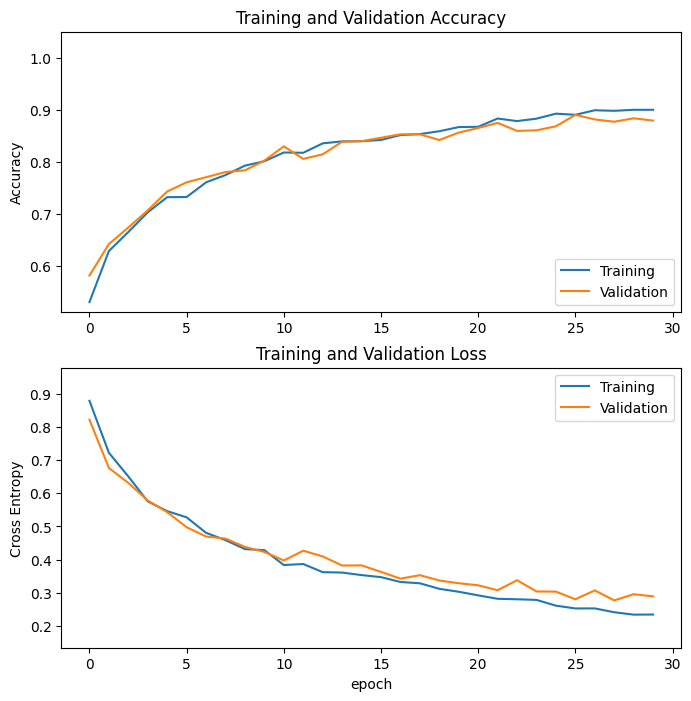

0.9060439467430115
Total elapsed time is 884.5976996421814


In [12]:
# top_dir =  "Data/Chronological Fold May 3/"
top_dir = "../Audio Data/Data/"
folds = sorted(glob.glob(top_dir + "/*"))
num_folds = len(folds)
print("Num folds = " + str(num_folds))
results = []
validation_subject = []
epochs =  50 if model_type is 'densenet' else 30 # convnext: 30, densenet: 50, resnet 20
class_names = ["Fail", "Pass"]


concat_predictions = []
concat_predict_score_mean = []
fold_labels = []
prob_avg = []
start_tic = time.time()
first_pass = True
for fold in folds:
  tic = time.time()
  training_dir = fold + "/Train/"
  test_dir = fold + "/Validation/"
  print(training_dir)

  train_dataset, validation_dataset, test_dataset = load_data(training_dir, None)
  model = get_model(training=True)

  weights = compute_weights(train_dataset, validation_dataset)

  # Early stopping and model checkpointing
  early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)
  #model_checkpoint = ModelCheckpoint('best_model.model', monitor='loss', mode='min', verbose=1, save_best_only=True)

  lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
  history = model.fit(train_dataset,
                    epochs=epochs,
                     validation_data=validation_dataset,
                    callbacks=[early_stopping, lr_scheduler_callback], class_weight=weights)
 
  results = get_performance(model, train_dataset)

  if first_pass:
    print(model.summary())
    first_pass = False
    
  plot_accuracy_and_loss(history)

  
  # Load best model
  #model = load_model('best_model.model')

  # Clear and proceed
  #K.clear_session()
  #del model

print(results)
print("Total elapsed time is " + str(time.time() - start_tic))
print(model)

1/1 [==============================] - 1s 1s/step


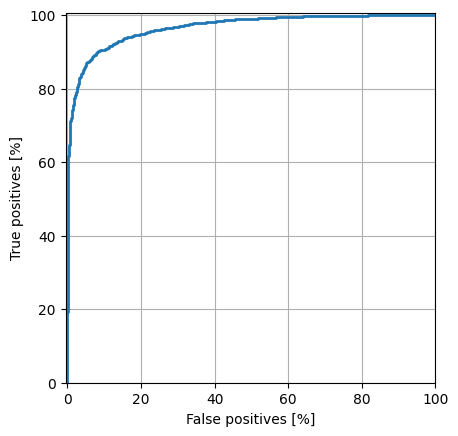

Auc: 0.967
Precision: 0.830, Recall: 0.907, F-Score: 0.867,
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1237
           1       0.95      0.90      0.93      2403

    accuracy                           0.91      3640
   macro avg       0.89      0.91      0.90      3640
weighted avg       0.91      0.91      0.91      3640



In [13]:
labels, predictions = predict_on_dataset(model, train_dataset)
plot_roc(labels, predictions,  "Result Images/train_clip_roc.png")
get_performance_metrics(labels, predictions)

# Save Weights

In [14]:
model.save_weights('Weights/' + model_type + '.h5' , overwrite=True)

# Run on test set

In [15]:
rootdir = top_dir + "Fold 0/Test/"
results = []
participant_labels = []
participant_predictions = []
concat_labels = []
tic = time.time()

test_model = get_model(training=False)
test_model.load_weights("Weights/" + model_type + ".h5")



for subdir, dirs, files in os.walk(rootdir):
    for dir in dirs:
        print(rootdir + dir)
        _, _, test_dataset = load_data(None, rootdir + dir)
        corrected_labels, corrected_predictions = predict_on_dataset(test_model, test_dataset)
    
        concat_labels = np.concatenate((concat_labels, corrected_labels), axis=0)
        concat_predictions = np.concatenate((concat_predictions, corrected_predictions), axis=0)
        predict_on_performance = 1-(np.count_nonzero(tf.where(corrected_predictions < 0.5, 0, 1) - corrected_labels))/len(corrected_labels)
        predict_score_mean = np.mean(corrected_predictions)
        concat_predict_score_mean.append(predict_score_mean)
        

        print("Labels " + str(corrected_labels))
        print("Predictions = " + str(tf.where(corrected_predictions < 0.5, 0, 1).numpy()))
        print("Label length = " + str(len(corrected_labels)))
        print("Predictions length = " + str(len(corrected_predictions)))
        print("Model performance (predict_on) " + str(predict_on_performance))
        #print(corrected_predictions)
        print("Prediction cumulative score = " + str(predict_score_mean))
        get_performance(model, test_dataset)
        results.append(predict_on_performance)
        prob_avg.append(np.mean(corrected_predictions))
        
        participant_labels.append(corrected_labels[0])
        participant_predictions.append(0 if predict_on_performance < 0.5 else 1)

        print("Elapsed time = " + str(time.time() - tic))
    break

CONVNEXT SELECTED
Number of layers = 151
Number of layers = 151
../Audio Data/Data/Fold 0/Test/Test Participant 1
Found 91 files belonging to 2 classes.
1/1 [==============================] - 3s 3s/step
Labels [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predictions = [1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1
 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0]
Label length = 91
Predictions length = 91
Model performance (predict_on) 0.8131868131868132
Prediction cumulative score = 0.7640397
3/3 [==============================] - 1s 445ms/step - loss: 0.4220 - accuracy: 0.7802
Test accuracy : 0.7802197933197021
Elapsed time = 8.782156467437744
../Audio Data/Data/Fold 0/Test/Test Participant 12
Found 70 files belonging to 2 classes.
1/1 [======================

## Single Clip Performance

Overall accuracy is 0.7198280506251618


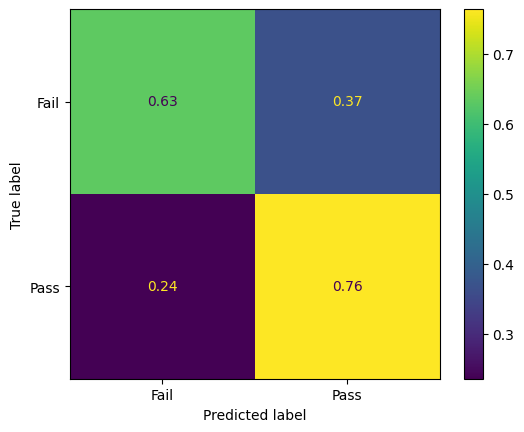

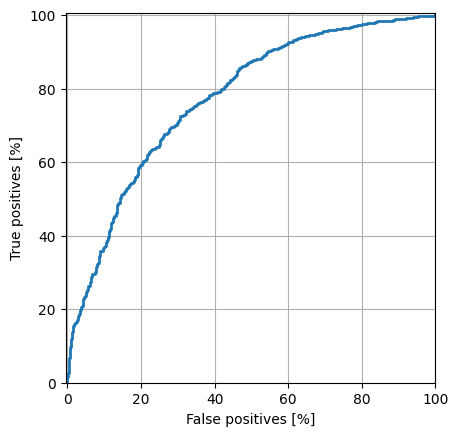

Auc: 0.774
Precision: 0.584, Recall: 0.634, F-Score: 0.608,
              precision    recall  f1-score   support

         0.0       0.58      0.63      0.61       650
         1.0       0.80      0.76      0.78      1247

    accuracy                           0.72      1897
   macro avg       0.69      0.70      0.69      1897
weighted avg       0.73      0.72      0.72      1897

Sensitivity = 0.6338461538461538
Specificity = 0.764234161988773
Precision = 0.5835694050991501
Recall = 0.6338461538461538


(0.6338461538461538, 0.764234161988773, 0.5835694050991501, 0.6338461538461538)

In [16]:
%matplotlib inline
%matplotlib inline
result_dict = []
i = 0
#print(folds)
for fold in folds:
  result_dict.append({"Fold": fold, "Accuracy": results[i]})
  i = i + 1
#print((prob_avg))

print("Overall accuracy is " + str(np.mean(results)))
plot_confusion_matrix(concat_labels, concat_predictions, class_names, "Result Images/clip_confusion.png")
plot_roc(concat_labels, concat_predictions,  "Result Images/clip_roc.png")
get_performance_metrics(concat_labels, concat_predictions)
predicted_labels = tf.where(concat_predictions < 0.5, 0, 1)
calculate_metrics(concat_labels, predicted_labels, class_of_interest=0)

# Participant Level Performance

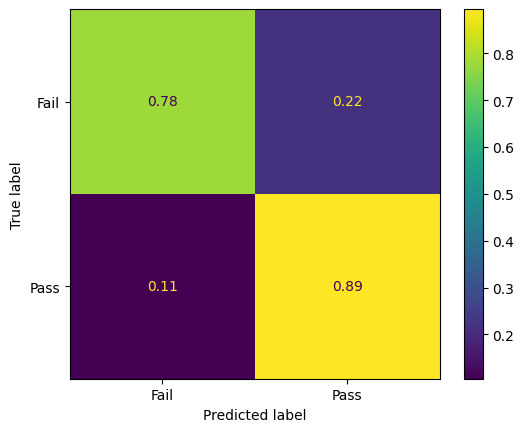

[0.7640397, 0.7881427, 0.6672466, 0.28041804, 0.64365727, 0.08887668, 0.73191893, 0.5619115, 0.75828725, 0.5971904, 0.84879375, 0.5319381, 0.6645541, 0.8351708, 0.47800678, 0.24814916, 0.8454398, 0.41702366, 0.61142415, 0.69432783, 0.6309318, 0.32708114, 0.30765274, 0.44293278, 0.74187434, 0.647073, 0.19008037, 0.73394096]
[1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
[1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1]


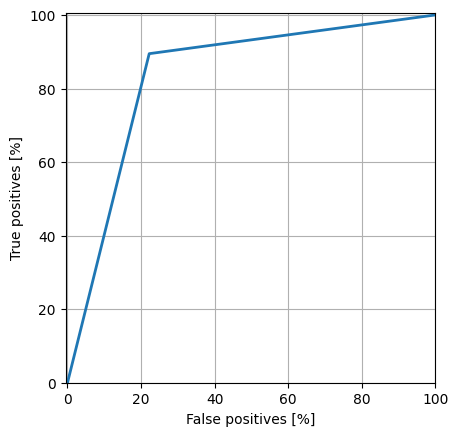

Auc: 0.912
Precision: 0.778, Recall: 0.778, F-Score: 0.778,
              precision    recall  f1-score   support

           0       0.78      0.78      0.78         9
           1       0.89      0.89      0.89        19

    accuracy                           0.86        28
   macro avg       0.84      0.84      0.84        28
weighted avg       0.86      0.86      0.86        28

Sensitivity = 0.7777777777777778
Specificity = 0.8947368421052632
Precision = 0.7777777777777778
Recall = 0.7777777777777778


(0.7777777777777778,
 0.8947368421052632,
 0.7777777777777778,
 0.7777777777777778)

In [17]:
i = 0
participant_predictions = []

for score in concat_predict_score_mean: # can also use prob_avg
    participant_predictions.append(1 if score > 0.5 else 0)
    i=i+1


plot_confusion_matrix(np.array(participant_labels), np.array(participant_predictions), class_names, "Result Images/participant_confusion.png")

print(concat_predict_score_mean)
print(participant_labels)
print(participant_predictions)
plot_roc(participant_labels, participant_predictions,  "Result Images/participant_roc.png")
get_performance_metrics(participant_labels, np.array(concat_predict_score_mean))
predicted_participant_labels = tf.where( np.array(concat_predict_score_mean) < 0.5, 0, 1)
calculate_metrics(participant_labels, predicted_participant_labels, class_of_interest=0)

# Integrated Gradients

In [ ]:
def read_image(file_name):
  image = tf.io.read_file(file_name)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  return image

In [ ]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}


In [ ]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()


In [ ]:
def top_k_predictions(img, k=2):
  image_batch = tf.expand_dims(img, 0)
  predictions = model(image_batch)
  probs = tf.nn.softmax(predictions, axis=-1)
  top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
  top_labels = imagenet_labels[tuple(top_idxs)]
  return top_labels, top_probs[0]


In [ ]:
for (name, img_tensor) in img_name_tensors.items():
  plt.imshow(img_tensor)
  plt.title(name, fontweight='bold')
  plt.axis('off')
  plt.show()

  pred_label, pred_prob = top_k_predictions(img_tensor)
  for label, prob in zip(pred_label, pred_prob):
    print(f'{label}: {prob:0.1%}')


In [1]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)

baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()


NameError: name 'tf' is not defined

In [2]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below

def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

interpolated_images = interpolate_images(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    alphas=alphas)

NameError: name 'tf' is not defined

In [ ]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();


# **Dummy Classifier to compare performance**


In [18]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(None, concat_labels)
dummy_predictions = dummy_clf.predict(np.ones((len(concat_labels),1)))
get_performance_metrics(concat_labels, dummy_predictions)

Auc: 0.500
Precision: 0.000, Recall: 0.000, F-Score: 0.000,
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       650
         1.0       0.66      1.00      0.79      1247

    accuracy                           0.66      1897
   macro avg       0.33      0.50      0.40      1897
weighted avg       0.43      0.66      0.52      1897

